In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#import data
df = pd.read_csv('data/Recidivism_Data_cleaned.csv')
df_original = df.copy()


In [2]:
# We only want to predict recidivism within 3 years
#We are also looking at just Males
df.drop(['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Gender'], axis=1, inplace=True)

# Remove variables thaat are determined only after prison release
df.drop(['Supervision_Risk_Score_First', 'Supervision_Level_First',
         'Violations_ElectronicMonitoring', 'Violations_FailToReport','Violations_FailToReport', 'Violations_MoveWithoutPermission',
         'Delinquency_Reports', 'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 
         'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive','DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 
         'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt'], axis=1, inplace=True)

### Data Preprocessing

In [3]:
#Chance all Booleans to Integers
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Dummy Variable for Race 
df['Race'] = df['Race'].map({'BLACK': 1, 'WHITE': 0})

# Change age to integer as opposed to float
df['Age_at_Release'] = df['Age_at_Release'].astype(int)

# Interger Encoded to for embeddings in NN
df['Prison_Offense'] = df['Prison_Offense'].map({category: idx for idx, category in enumerate(df['Prison_Offense'].unique())})
df['Education_Level'] = df['Education_Level'].map({'Less than HS diploma': 0, 'High School Diploma': 1, 'At least some college': 2})

# Make Recidivism_Within_3years the last column
cols = [col for col in df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
df = df[cols]

In [4]:
# Variables to normalize
columns_to_normalize = ['Age_at_Release', 'Prison_Years']  # add other columns here

# Apply Standardization
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

#Split Train and Test Data
train_df = df[df['Training_Sample'] == 1]
test_df = df[df['Training_Sample'] == 0]
train_df = train_df.drop(columns=['Training_Sample'])
test_df = test_df.drop(columns=['Training_Sample'])

### MLP

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [7]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(test_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(31, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [9]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [10]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [11]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)
    val_loss, val_acc = eval(model, test_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 27/27 [00:00<00:00, 496.03it/s]


Epoch: 1 Train Loss: 0.6407421655261639 Val Loss: 0.6256000906276828 Val Acc: 0.6540761265859706


100%|██████████| 27/27 [00:00<00:00, 489.91it/s]


Epoch: 2 Train Loss: 0.604353607760217 Val Loss: 0.60661425246465 Val Acc: 0.6685139273734869


100%|██████████| 27/27 [00:00<00:00, 484.76it/s]


Epoch: 3 Train Loss: 0.5954650371247032 Val Loss: 0.6022610958609651 Val Acc: 0.6752224004666764


100%|██████████| 27/27 [00:00<00:00, 486.30it/s]


Epoch: 4 Train Loss: 0.5915989625251132 Val Loss: 0.6037297055953199 Val Acc: 0.6727431821496281


100%|██████████| 27/27 [00:00<00:00, 476.21it/s]


Epoch: 5 Train Loss: 0.5889616199104001 Val Loss: 0.5990380440523938 Val Acc: 0.6794516552428176


100%|██████████| 27/27 [00:00<00:00, 494.06it/s]


Epoch: 6 Train Loss: 0.5896603961452633 Val Loss: 0.6047411576571888 Val Acc: 0.67434738223713


100%|██████████| 27/27 [00:00<00:00, 248.48it/s]


Epoch: 7 Train Loss: 0.5866245030414357 Val Loss: 0.5978230975086946 Val Acc: 0.6809100189587283


100%|██████████| 27/27 [00:00<00:00, 493.94it/s]


Epoch: 8 Train Loss: 0.5857779460714511 Val Loss: 0.6069692723671445 Val Acc: 0.6727431821496281


100%|██████████| 27/27 [00:00<00:00, 481.02it/s]


Epoch: 9 Train Loss: 0.5851814378959828 Val Loss: 0.6022254743450182 Val Acc: 0.6790141461280443


100%|██████████| 27/27 [00:00<00:00, 502.41it/s]


Epoch: 10 Train Loss: 0.583551925991135 Val Loss: 0.5975737427420391 Val Acc: 0.6839725827621409


100%|██████████| 27/27 [00:00<00:00, 473.99it/s]


Epoch: 11 Train Loss: 0.5822352659173772 Val Loss: 0.6047671020196134 Val Acc: 0.6733265276359924


100%|██████████| 27/27 [00:00<00:00, 480.60it/s]


Epoch: 12 Train Loss: 0.5821326920463075 Val Loss: 0.6005252866663633 Val Acc: 0.6759515823246318


100%|██████████| 27/27 [00:00<00:00, 487.51it/s]


Epoch: 13 Train Loss: 0.5798030538732674 Val Loss: 0.5970482244702979 Val Acc: 0.6797433279859997


100%|██████████| 27/27 [00:00<00:00, 486.29it/s]


Epoch: 14 Train Loss: 0.5788457417773096 Val Loss: 0.5981479850336224 Val Acc: 0.680326673472364


100%|██████████| 27/27 [00:00<00:00, 472.10it/s]

Epoch: 15 Train Loss: 0.5792906743571907 Val Loss: 0.6021209397242266 Val Acc: 0.6756599095814496


In [18]:
@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    all_preds = []

    for data, target in loader:
        out = model(data)
        prob = torch.sigmoid(out)
        all_probs.extend(prob.view(-1).cpu().numpy())
        all_preds.extend((prob >= 0.5).long().view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    return all_probs, all_targets, all_preds

# Calculate probabilities and actual labels on the test set
all_probs, all_targets, all_preds = get_predictions(model, test_loader)

# Now, you can calculate the Brier score
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.2079


ROC AUC: 0.7211


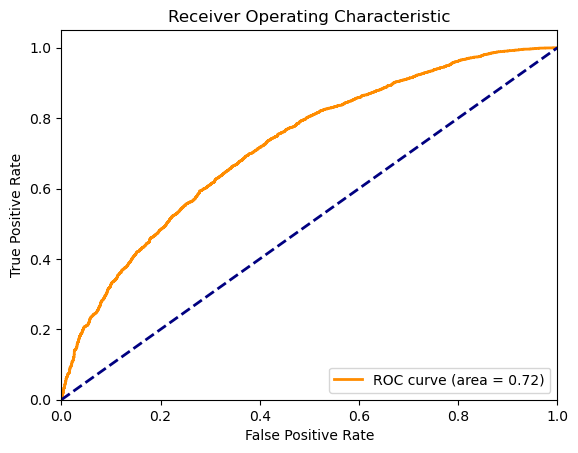

In [19]:
# Calculate ROC AUC
roc_auc = roc_auc_score(all_targets, all_probs)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


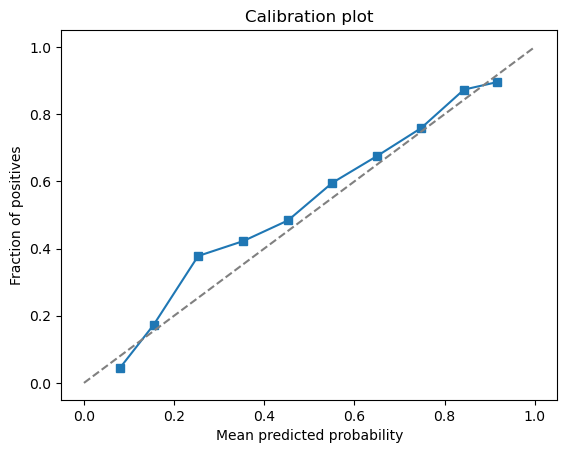

In [20]:
# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(all_targets, all_probs, n_bins=10)

# Plot calibration plot
plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.show()


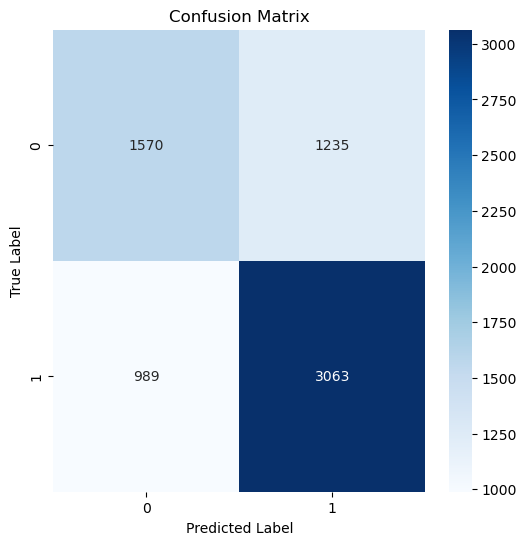

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()